In [1]:
import numpy

In [2]:
a = numpy.array([7, 0, 42, -11, 212])
print(a[2]) # select the 3rd item (0 indexing)

42


In [3]:
s = set([7, 0, 42, -11, 212])
print(s[2]) # select the 3rd value?

TypeError: 'set' object is not subscriptable

In [4]:
s = set(enumerate([7, 0, 42, -11, 212]))

In [5]:
print(s)

{(0, 7), (4, 212), (2, 42), (1, 0), (3, -11)}


In [6]:
# select the 3rd value
for rowid, value in s:  # enumerate over all of the rows
    if rowid == 2:      # if the first column is 2
        print(value)    # print the second column

42


In [7]:
# constant time lookup for rows using the first column
# (because a Python dictionary is a hash-map)
rowid_index = {row[0]: row for row in s}
print(rowid_index)
# what if rowid isn't unique? would this work?

# print the 2nd column where the first column is 2
print(rowid_index[2][1])
# ...a bit of ugly syntax, IMO

{0: (0, 7), 4: (4, 212), 2: (2, 42), 1: (1, 0), 3: (3, -11)}
42


In [8]:
# searching for value 42, what's the row id?

# for the array, we have to enumerate the values
for rowid, value in enumerate(a):
    if value == 42:
        print(rowid)
# or in numpy syntax (it's still a linear search)
print(numpy.where(a == 42))

2
(array([2]),)


In [9]:
# the set already has rowid
for rowid, value in s:
    if value == 42:
        print(rowid)

2


---

In [10]:
# sqlite 3 comes with all python installations
from sqlite3 import connect

# create an in-memory database (not backed to disk)
# (volatile, will go away when Python stops)
memory = connect(':memory:')

# create an non-volatile, on-disk database
# if it already exists, it will open it;
# otherwise, it will create a new empty database
db = connect('db.sqlite')

In [11]:
# some helper functions to insert and query
import sqlitehelpers as sql

# insert raw numpy arrays into a table
sql.columns2sqlite(db, 'mydataset', 
                   {'x': numpy.array([0, 1, 2, 3]), 
                    'y': numpy.array([3.0, 2.0, 1.0, 0.0]),
                    'z': numpy.array(['a', 'b', 'c', 'd'])}, 
                   ['x', 'y', 'z'])
# or csv data
sql.csv2sqlite(db, 'mtcars', 'data/mtcars.csv')
sql.csv2sqlite(db, 'iris', 'data/iris.csv')

[('', 'int'),
 ('SepalLength', 'real'),
 ('SepalWidth', 'real'),
 ('PetalLength', 'real'),
 ('PetalWidth', 'real'),
 ('Species', 'string')]

In [12]:
# a cursor is an iterator, given some query
cursor = db.cursor()

# the simplest query is to select all data
# SQL statement: select all rows, and all columns 
# (* means all columns) from mydataset
cursor.execute('select * from mydataset')
# SELECT <column_names> FROM <table_name>

In [13]:
# in Python, a cursor is an iterator
for row in cursor:
    print(row)

(0, 3.0, 'a')
(1, 2.0, 'b')
(2, 1.0, 'c')
(3, 0.0, 'd')


In [14]:
# retrieve as a list of arrays (column oriented)
print(sql.query2colarr(db, 'select * from mydataset'))
# retrieve as a dict of arrays (column oriented)
print(sql.query2coldict(db, 'select * from mydataset'))
# retrieve as a structured array (row oriented)
print(sql.query2struct(db, 'select * from mydataset', [int, float, '<U1']))
# retrieve as a 2D array (row oriented)
print(sql.query2array(db, 'select * from mydataset'))
# retrieve as a CSV
sql.query2csv(db, 'select * from mydataset', 'new.csv')

[array([0, 1, 2, 3]), array([3., 2., 1., 0.]), array(['a', 'b', 'c', 'd'], dtype='<U1')]
{'x': array([0, 1, 2, 3]), 'y': array([3., 2., 1., 0.]), 'z': array(['a', 'b', 'c', 'd'], dtype='<U1')}
[(0, 3., 'a') (1, 2., 'b') (2, 1., 'c') (3, 0., 'd')]
[['0' '3.0' 'a']
 ['1' '2.0' 'b']
 ['2' '1.0' 'c']
 ['3' '0.0' 'd']]


In [15]:
# database introspection through helper library
print(sql.tablenames(db))
print(sql.tableschema(db, 'mydataset'))
print(sql.columnnames(db, 'select * from mtcars'))

['mydataset', 'mtcars', 'iris']
[('x', 'int'), ('y', 'real'), ('z', 'string')]
['name', 'mpg', 'cyl', 'disp', 'hp', 'drat', 'wt', 'qsec', 'vs', 'am', 'gear', 'carb']


In [16]:
# selecting only name, mpg, and cyl from mtcars
# since there are 12 columns
names, mpgs, cyls = sql.query2colarr(db, 
'select name, mpg, cyl from mtcars') # SQL query

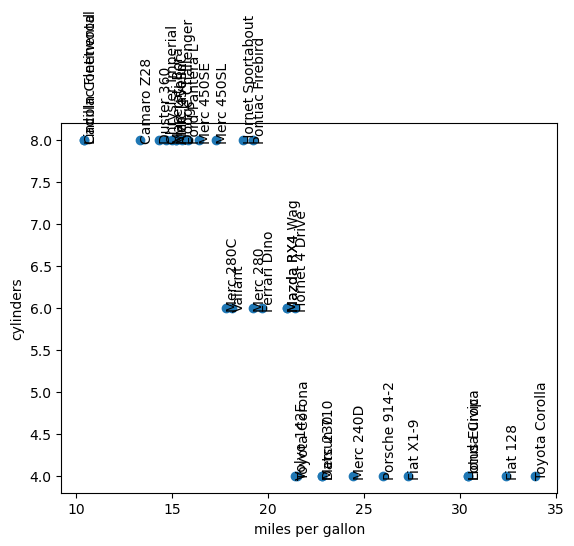

In [17]:
%matplotlib inline
from matplotlib import pyplot
pyplot.scatter(mpgs, cyls)
pyplot.xlabel('miles per gallon')
pyplot.ylabel('cylinders')
for i, n in enumerate(names):
    pyplot.annotate(n, (mpgs[i], cyls[i]), rotation=90)

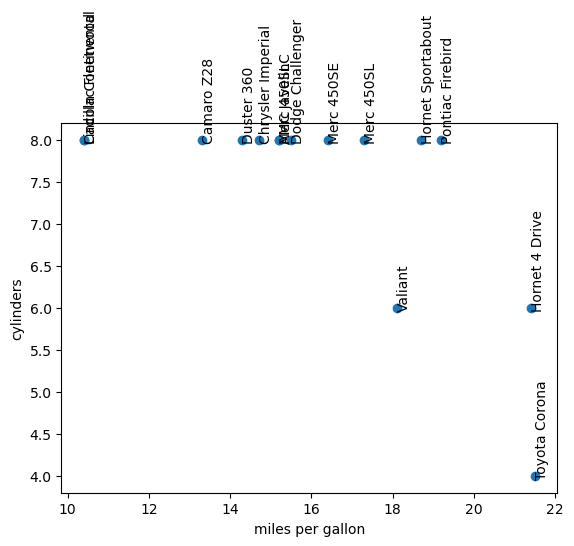

In [18]:
# less than 4 gears
names, mpgs, cyls = sql.query2colarr(db, 
'select name, mpg, cyl from mtcars where gear < 4') # SQL query
pyplot.scatter(mpgs, cyls)
pyplot.xlabel('miles per gallon')
pyplot.ylabel('cylinders')
for i, n in enumerate(names):
    pyplot.annotate(n, (mpgs[i], cyls[i]), rotation=90)

In [19]:
# horsepower of the top 3 miles per gallon
print(sql.query2struct(db,
'select name, hp from mtcars order by mpg desc limit 3', ['<U16', float]))
# quarter mile time for lowest 3 hp cars
print(sql.query2struct(db,
'select name, qsec from mtcars order by hp limit 3', ['<U16', float]))

[('Toyota Corolla', 65.) ('Fiat 128', 66.) ('Honda Civic', 52.)]
[('Honda Civic', 18.52) ('Merc 240D', 20.  ) ('Toyota Corolla', 19.9 )]


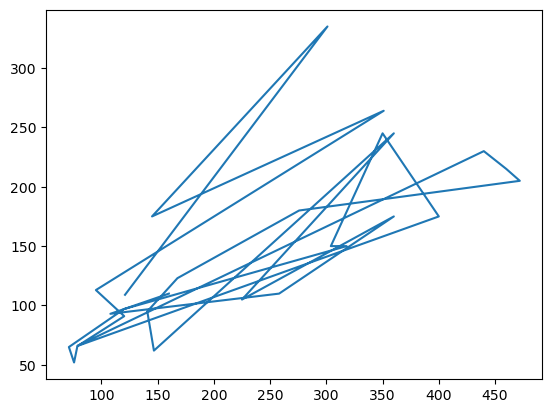

In [20]:
# if we don't order by displacement, the
# line plot is a scribble
disp, hp = sql.query2colarr(db, 
'select disp, hp from mtcars')
pyplot.plot(disp, hp)

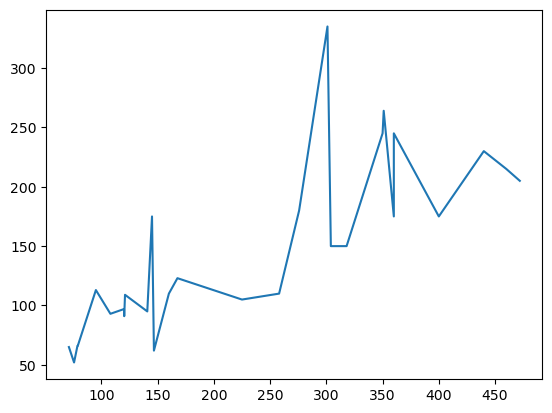

In [21]:
# correctly ordered (assuming there's a linear-ish
# relationship between displacement and horsepower)
disp, hp = sql.query2colarr(db, 
'select disp, hp from mtcars order by disp')
pyplot.plot(disp, hp)

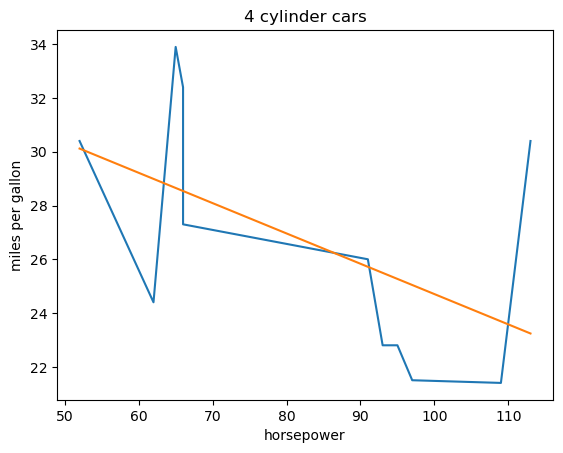

In [22]:
hp, mpg = sql.query2colarr(db, 
'select hp, mpg from mtcars where cyl = 4 order by hp')
from scipy.stats import linregress
regress = linregress(hp, mpg)
pyplot.plot(hp, mpg)
pyplot.title('4 cylinder cars')
pyplot.xlabel('horsepower')
pyplot.ylabel('miles per gallon')
pyplot.plot(hp, regress.intercept + regress.slope*hp)

In [23]:
cyl, avghp, minhp, maxhp, diff = sql.query2colarr(db,
"""
select cyl, avg(hp), min(hp), max(hp), max(hp) - min(hp)
from mtcars
group by cyl
order by cyl
""")

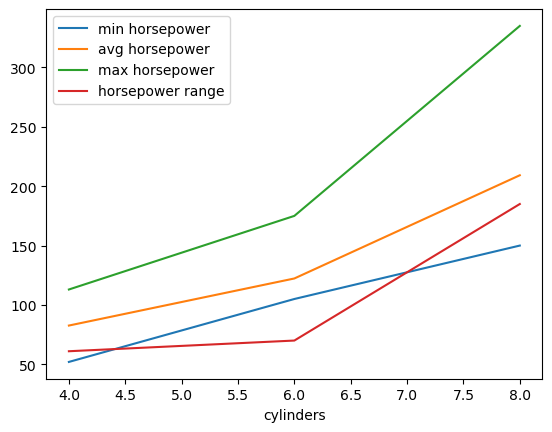

In [24]:
pyplot.plot(cyl, minhp, label='min horsepower')
pyplot.plot(cyl, avghp, label='avg horsepower')
pyplot.plot(cyl, maxhp, label='max horsepower')
pyplot.plot(cyl, diff, label='horsepower range')
pyplot.xlabel('cylinders')
pyplot.legend()

In [25]:
# our previous query can be stored
# as a named view 'cyltohp'
# in the database
db.execute(
"""
create view cyltohp as
select cyl, 
avg(hp) as avghp, 
min(hp) as minhp, 
max(hp) as maxhp, 
max(hp) - min(hp) as hprange
from mtcars
group by cyl
order by cyl
""")

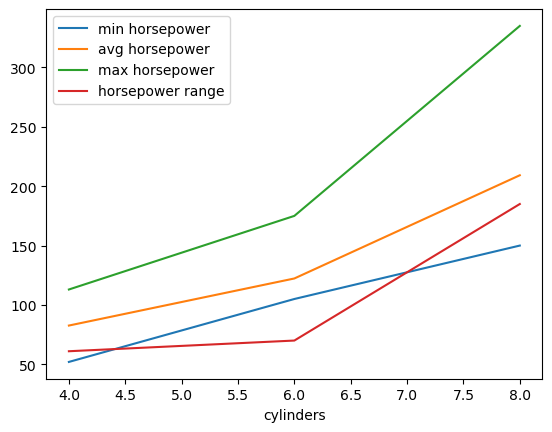

In [26]:
# then we can plot the same data as we did before
cyl, avghp, minhp, maxhp, diff = sql.query2colarr(db,
"select * from cyltohp")
pyplot.plot(cyl, minhp, label='min horsepower')
pyplot.plot(cyl, avghp, label='avg horsepower')
pyplot.plot(cyl, maxhp, label='max horsepower')
pyplot.plot(cyl, diff, label='horsepower range')
pyplot.xlabel('cylinders')
pyplot.legend()

In [27]:
# we can even do a select on the view
# thereby combining queries together

# print the maxhp / minhp ratio
# for cylinders greater than 4
print(sql.query2struct(db,
'select cyl, maxhp/(1.0*minhp) from cyltohp where cyl > 4', ['<f8', '<f8']))
# the 1.0*minhp to is convert it to a real

[(6., 1.66666667) (8., 2.23333333)]


In [28]:
# what's the deviation of horsepower
# from its average horsepower
# in its cylinder group
# plotted against mpg
names, cyls, mpgs, diff = sql.query2colarr(db,
"""
select name, mtcars.cyl, mpg, hp - avghp
from cyltohp
inner join mtcars
on mtcars.cyl = cyltohp.cyl
""")
# join data on horsepower statistics
# using cylinders as the join key

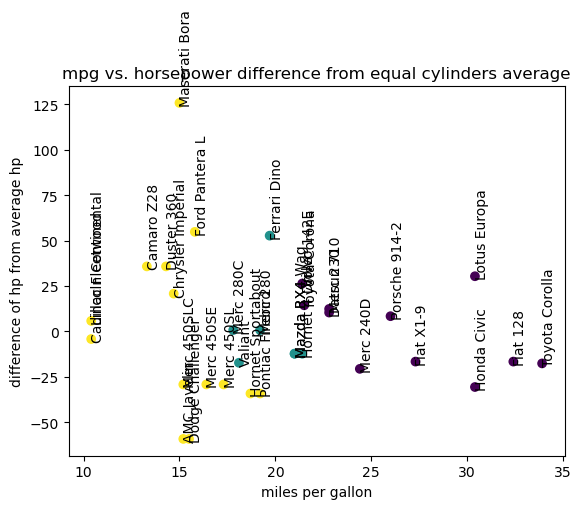

In [29]:
pyplot.scatter(mpgs, diff, c=cyls)
pyplot.xlabel('miles per gallon')
pyplot.ylabel('difference of hp from average hp')
pyplot.title('mpg vs. horsepower difference from equal cylinders average')
for i, n in enumerate(names):
    pyplot.annotate(n, (mpgs[i], diff[i]), rotation=90)

---

In [30]:
from sqlite3 import connect
import sqlitehelpers as sql
pv_data = connect('pv.sqlite')
sql.csv2sqlite(pv_data, 'galaxy', 'data/isolated_galaxy.csv.gz', gzipped=True)

[('x', 'real'),
 ('y', 'real'),
 ('z', 'real'),
 ('particle_index', 'int'),
 ('particle_mass', 'real'),
 ('particle_type', 'int'),
 ('particle_velocity_x', 'real'),
 ('particle_velocity_y', 'real'),
 ('particle_velocity_z', 'real')]